# A1 - DNN using pytorch

This notebook uses the classic [MNIST handwritten digit](https://git-disl.github.io/GTDLBench/datasets/mnist_datasets/) dataset, which contains digit 0-9 images of size 28*28. Our goal is to build a dense neural network to predict the class of digit.

For standarization purposes, you are required to use pytorch.

In [1]:
###checking if we are getting GPU in colab
###if not, Runtime → Change runtime type and Set Hardware accelerator to GPU
!nvidia-smi

Sun Jan 18 03:25:09 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Using device:', device)

Using device: mps


## The MNIST dataset - Preprocessing


### Get the data
MNIST dataset is provided by torch directly. The following codes show how to load it.



In [2]:
help(datasets.MNIST)

Help on class MNIST in module torchvision.datasets.mnist:

class MNIST(torchvision.datasets.vision.VisionDataset)
 |  MNIST(root: Union[str, pathlib.Path], train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None
 |
 |  `MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
 |
 |  Args:
 |      root (str or ``pathlib.Path``): Root directory of dataset where ``MNIST/raw/train-images-idx3-ubyte``
 |          and  ``MNIST/raw/t10k-images-idx3-ubyte`` exist.
 |      train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
 |          otherwise from ``t10k-images-idx3-ubyte``.
 |      transform (callable, optional): A function/transform that  takes in a PIL image
 |          and returns a transformed version. E.g, ``transforms.RandomCrop``
 |      target_transform (callable, optional): A function/transform that takes in the
 |          target and transforms it.
 |      download (bool, opti

In [3]:
# the data, shuffled and split between train and test sets
# (downloads automatically if not present)
train_ds = datasets.MNIST(root='./data', train=True, download=True)
test_ds  = datasets.MNIST(root='./data', train=False, download=True)

X_train_pre = train_ds.data.numpy()     # (N, 28, 28), uint8
y_train_pre = train_ds.targets.numpy()  # (N,), int64
X_test_pre  = test_ds.data.numpy()
y_test_pre  = test_ds.targets.numpy()

### Reshape and normalize the features

In [4]:
input_dim = 784 # 28*28
X_train = X_train_pre.reshape(X_train_pre.shape[0], input_dim)
X_test = X_test_pre.reshape(X_test_pre.shape[0], input_dim)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('training data shape:', X_train.shape)
print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

training data shape: (60000, 784)
60000 train samples, 10000 test samples


### convert class vectors to binary class matrices
convert class label to one-hot coding

In [5]:
y_train_pre[:5]

array([5, 0, 4, 1, 9])

In [6]:
num_classes = 10 # 0-9
# keep one-hot labels (to match the original notebook flow)
y_train = np.eye(num_classes, dtype=np.float32)[y_train_pre]
y_test = np.eye(num_classes, dtype=np.float32)[y_test_pre]

# the first 5 samples are 5,0,4,1,9
y_train[:5,]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [7]:
validation_split = 0.166667
index = np.random.permutation(X_train.shape[0])

train_idx = int(X_train.shape[0]*validation_split)

X_val, X_train = X_train[index[:train_idx]], X_train[index[train_idx:]]
y_val, y_train = y_train[index[:train_idx]], y_train[index[train_idx:]]

print('training data shape:', X_train.shape)
print('{} train samples, {} validation samples, {} test samples'\
      .format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

training data shape: (50000, 784)
50000 train samples, 10000 validation samples, 10000 test samples


## The models

### Build the model **1**

model 1: Build a 784-input 10-output perceptron, with no hidden layer for multi-class classification. This model is also known as the [multinomial logistic regression model](https://en.wikipedia.org/wiki/Multinomial_logistic_regression).

In [15]:
### Helper functions

import sys

class History:
    def __init__(self):
        self.history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
        self.epoch = []


def model_summary(model: nn.Module, input_dim: int = 784):
    """Simple summary: architecture + parameter counts."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(model)
    print(f"\nTotal params: {total:,}")
    print(f"Trainable params: {trainable:,}")
    sys.stdout.flush()



def make_loaders(X_train, y_train_idx, X_val, y_val_idx, batch_size=128):
    Xtr = torch.from_numpy(X_train).float()
    ytr = torch.from_numpy(y_train_idx).long()
    Xva = torch.from_numpy(X_val).float()
    yva = torch.from_numpy(y_val_idx).long()

    train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(Xva, yva), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs,
    metric_fn,
    early_stop_patience = None,
):
    history = History()
    best_val = float('inf')
    best_state = None
    patience_left = early_stop_patience

    for ep in range(epochs):
        #train
        model.train()
        train_loss_sum, train_correct, train_n = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            bs = xb.size(0)
            train_loss_sum += loss.item() * bs
            train_correct += metric_fn(logits, yb)
            train_n += bs

        train_loss = train_loss_sum / train_n
        train_acc = train_correct / train_n

        # --- val ---
        model.eval()
        val_loss_sum, val_correct, val_n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                bs = xb.size(0)
                val_loss_sum += loss.item() * bs
                val_correct += metric_fn(logits, yb)
                val_n += bs

        val_loss = val_loss_sum / val_n
        val_acc = val_correct / val_n

        history.epoch.append(ep)
        history.history['loss'].append(train_loss)
        history.history['val_loss'].append(val_loss)
        history.history['accuracy'].append(train_acc)
        history.history['val_accuracy'].append(val_acc)

        print(f"Epoch {ep+1:02d}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

        # --- early stopping (optional) ---
        if early_stop_patience is not None:
            if val_loss < best_val - 1e-8:
                best_val = val_loss
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_left = early_stop_patience
            else:
                patience_left -= 1
                if patience_left < 0:
                    print('Early stopping triggered.')
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history


def evaluate_model(model, X, y_idx, batch_size=256):
    model.eval()
    Xte = torch.from_numpy(X).float()
    yte = torch.from_numpy(y_idx).long()
    loader = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    loss_sum, correct, n = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            bs = xb.size(0)
            loss_sum += loss.item() * bs
            correct += (logits.argmax(dim=1) == yb).sum().item()
            n += bs
    return loss_sum / n, correct / n


def predict_proba(model, X, batch_size=256):
    model.eval()
    X_ = torch.from_numpy(X).float()
    loader = DataLoader(TensorDataset(X_), batch_size=batch_size, shuffle=False)
    probs = []
    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs.append(F.softmax(logits, dim=1).cpu().numpy())
    return np.concatenate(probs, axis=0)

In [16]:
# Model: Multi-output Perceptron (multinomial logistic regression)
class Perceptron(nn.Module):
    def __init__(self, input_dim=784, num_classes=10):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


model = Perceptron().to(device)

# CrossEntropyLoss expects class indices, not one-hot vectors
# Fill in the following
y_train_idx = y_train.argmax(axis=1)
y_val_idx = y_val.argmax(axis=1)
y_test_idx = y_test.argmax(axis=1)


### make loaders with batchsize = 128
train_loader, val_loader = make_loaders(X_train, y_train_idx, X_val, y_val_idx, batch_size=128)


###What criterion should we use?
criterion = nn.CrossEntropyLoss()

###let us use RMSprop with lr = 0.001
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)


# accuracy metric: number of correct predictions
metric_fn = lambda logits, yb: (logits.argmax(dim=1) == yb).sum().item()

### Inspect the model

In [17]:
model_summary(model)

Perceptron(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

Total params: 7,850
Trainable params: 7,850


### Train the model

In [18]:
###Let us use EPOCHS = 20

EPOCHS = 20

history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=EPOCHS,
    metric_fn=metric_fn,
)

Epoch 01/20 - loss: 0.5321 - acc: 0.8699 - val_loss: 0.3677 - val_acc: 0.9021
Epoch 02/20 - loss: 0.3414 - acc: 0.9064 - val_loss: 0.3180 - val_acc: 0.9126
Epoch 03/20 - loss: 0.3096 - acc: 0.9141 - val_loss: 0.2997 - val_acc: 0.9171
Epoch 04/20 - loss: 0.2938 - acc: 0.9183 - val_loss: 0.2873 - val_acc: 0.9188
Epoch 05/20 - loss: 0.2848 - acc: 0.9206 - val_loss: 0.2825 - val_acc: 0.9198
Epoch 06/20 - loss: 0.2781 - acc: 0.9228 - val_loss: 0.2788 - val_acc: 0.9200
Epoch 07/20 - loss: 0.2728 - acc: 0.9243 - val_loss: 0.2756 - val_acc: 0.9213
Epoch 08/20 - loss: 0.2687 - acc: 0.9255 - val_loss: 0.2759 - val_acc: 0.9222
Epoch 09/20 - loss: 0.2659 - acc: 0.9258 - val_loss: 0.2703 - val_acc: 0.9237
Epoch 10/20 - loss: 0.2632 - acc: 0.9282 - val_loss: 0.2684 - val_acc: 0.9246
Epoch 11/20 - loss: 0.2606 - acc: 0.9277 - val_loss: 0.2678 - val_acc: 0.9252
Epoch 12/20 - loss: 0.2585 - acc: 0.9285 - val_loss: 0.2670 - val_acc: 0.9228
Epoch 13/20 - loss: 0.2565 - acc: 0.9293 - val_loss: 0.2653 - va

Plot historical training and validation losses

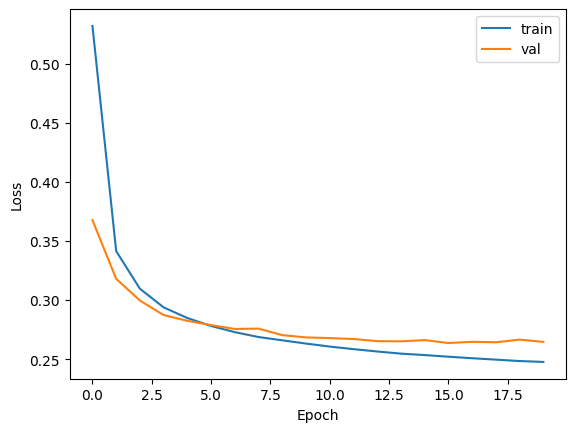

In [19]:
def plot_history_loss(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="train")
    plt.plot(hist['epoch'], hist['val_loss'], label="val")
    plt.legend()
    plt.show()

plot_history_loss(history)


Plot historical training and validation accuracy

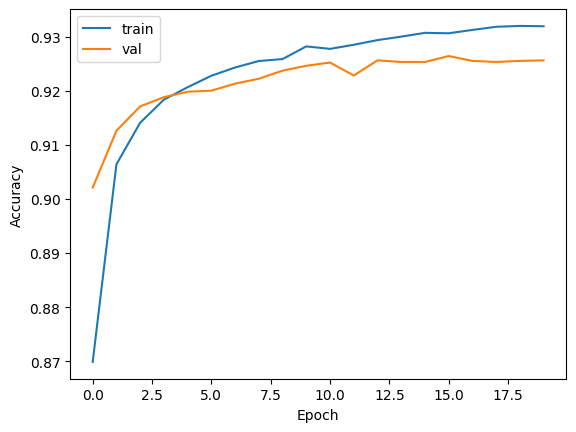

In [20]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label="train")
    plt.plot(hist['epoch'], hist['val_accuracy'], label="val")
    plt.legend()
    plt.show()

plot_history(history)


### Evaluate the model

In [21]:
_, acc = evaluate_model(model, X_test, y_test_idx)
print("Testing set accuracy: {:.2f}%".format(acc*100))


Testing set accuracy: 92.77%


### Build the model **2**: Two-layer fully-connected NN

In [22]:
# Please fill in the blanks
# Two-layer fully-connected NN
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512, num_classes=10):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = TwoLayerNN().to(device)


###same as model 1
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
metric_fn = lambda logits, yb: (logits.argmax(dim=1) == yb).sum().item()

In [23]:
model_summary(model)

TwoLayerNN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Total params: 407,050
Trainable params: 407,050


### Train the model

In [24]:
EPOCHS = 20

history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=EPOCHS,
    metric_fn=metric_fn,
)


Epoch 01/20 - loss: 0.2647 - acc: 0.9220 - val_loss: 0.1645 - val_acc: 0.9487
Epoch 02/20 - loss: 0.1168 - acc: 0.9654 - val_loss: 0.1092 - val_acc: 0.9661
Epoch 03/20 - loss: 0.0788 - acc: 0.9760 - val_loss: 0.0978 - val_acc: 0.9686
Epoch 04/20 - loss: 0.0564 - acc: 0.9835 - val_loss: 0.0732 - val_acc: 0.9767
Epoch 05/20 - loss: 0.0422 - acc: 0.9872 - val_loss: 0.0736 - val_acc: 0.9776
Epoch 06/20 - loss: 0.0309 - acc: 0.9912 - val_loss: 0.0714 - val_acc: 0.9784
Epoch 07/20 - loss: 0.0226 - acc: 0.9936 - val_loss: 0.0755 - val_acc: 0.9769
Epoch 08/20 - loss: 0.0175 - acc: 0.9951 - val_loss: 0.0704 - val_acc: 0.9800
Epoch 09/20 - loss: 0.0136 - acc: 0.9962 - val_loss: 0.0719 - val_acc: 0.9794
Epoch 10/20 - loss: 0.0103 - acc: 0.9974 - val_loss: 0.0647 - val_acc: 0.9826
Epoch 11/20 - loss: 0.0083 - acc: 0.9977 - val_loss: 0.0699 - val_acc: 0.9805
Epoch 12/20 - loss: 0.0056 - acc: 0.9988 - val_loss: 0.0730 - val_acc: 0.9819
Epoch 13/20 - loss: 0.0053 - acc: 0.9986 - val_loss: 0.0798 - va

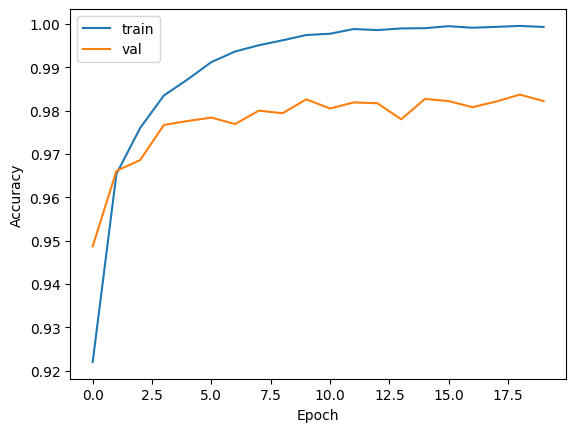

In [25]:
plot_history(history)

### Evaluate the model

In [26]:
_, acc = evaluate_model(model, X_test, y_test_idx)
print("Testing set accuracy: {:.2f}%".format(acc*100))


Testing set accuracy: 97.97%


### Make predictions for testing data

In [27]:
###Make precitions for X_test
y_pred = predict_proba(model, X_test).argmax(axis=1)
y_pred[:5]

array([7, 2, 1, 0, 4])

### Visualize the predictions.
#### Does your algorithm work as expected?

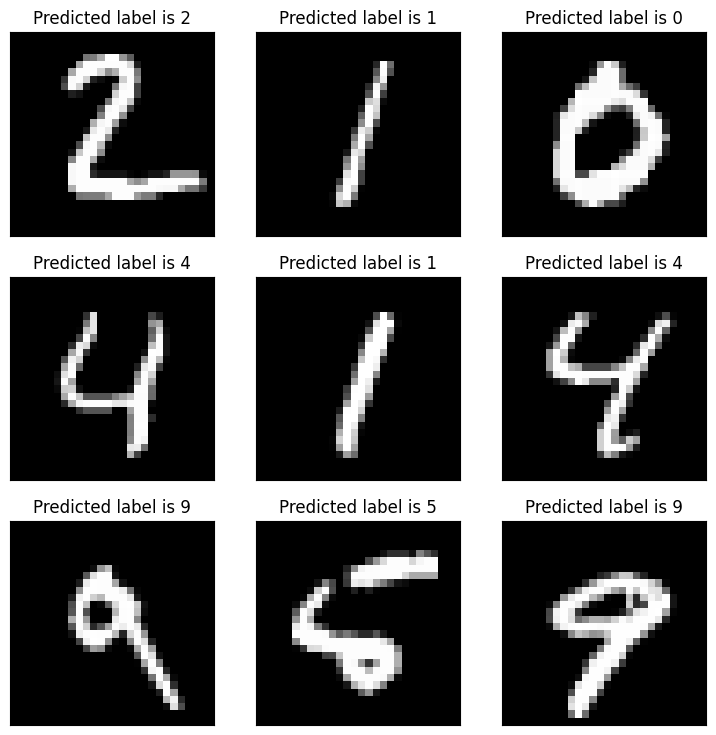

In [28]:
fig = plt.figure(figsize=(9, 9))
col = 3
row = 3
for i in range(1, col*row +1):
    pred = y_pred[i]
    img = X_test_pre[i,:]
    fig.add_subplot(row, col, i)
    plt.title('Predicted label is {}'.format(pred))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
plt.show()

### Build the model **3**: Model 2 with early stopping

In [29]:
# Build a new model (same architecture as above)
model = TwoLayerNN().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
metric_fn = lambda logits, yb: (logits.argmax(dim=1) == yb).sum().item()

### Train the model with early stopping

Early stopping can be implemented by creating a custom class to monitor the validation loss or another metric and halt the training process if no improvement is observed for a specified number of epochs (patience). Libraries like PyTorch Lightning offer a built-in EarlyStopping callback that automates this process. In our code, we have already set up a patience parameter to control early stopping.

Patience: Number of epochs with no improvement after which training will be stopped. Defaults to 0.

In [30]:
EPOCHS = 20

# Early stopping: stop if val_loss doesn't improve for 2 epochs
# Fill in the following blanks

history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=EPOCHS,
    metric_fn=metric_fn,
    early_stop_patience=2,
)

Epoch 01/20 - loss: 0.2725 - acc: 0.9198 - val_loss: 0.1461 - val_acc: 0.9556
Epoch 02/20 - loss: 0.1186 - acc: 0.9648 - val_loss: 0.1244 - val_acc: 0.9624
Epoch 03/20 - loss: 0.0782 - acc: 0.9768 - val_loss: 0.0927 - val_acc: 0.9713
Epoch 04/20 - loss: 0.0562 - acc: 0.9833 - val_loss: 0.0706 - val_acc: 0.9773
Epoch 05/20 - loss: 0.0409 - acc: 0.9886 - val_loss: 0.0662 - val_acc: 0.9795
Epoch 06/20 - loss: 0.0300 - acc: 0.9914 - val_loss: 0.0681 - val_acc: 0.9803
Epoch 07/20 - loss: 0.0227 - acc: 0.9939 - val_loss: 0.0655 - val_acc: 0.9811
Epoch 08/20 - loss: 0.0167 - acc: 0.9957 - val_loss: 0.0753 - val_acc: 0.9784
Epoch 09/20 - loss: 0.0130 - acc: 0.9968 - val_loss: 0.0671 - val_acc: 0.9815
Epoch 10/20 - loss: 0.0104 - acc: 0.9972 - val_loss: 0.0620 - val_acc: 0.9836
Epoch 11/20 - loss: 0.0083 - acc: 0.9978 - val_loss: 0.0837 - val_acc: 0.9776
Epoch 12/20 - loss: 0.0065 - acc: 0.9984 - val_loss: 0.0720 - val_acc: 0.9819
Epoch 13/20 - loss: 0.0043 - acc: 0.9992 - val_loss: 0.0899 - va

### Evaluate the model

In [31]:
_, acc = evaluate_model(model, X_test, y_test_idx)
print("Testing set accuracy: {:.2f}%".format(acc*100))


Testing set accuracy: 98.09%


### What are your findings?

**Model Comparison Summary:**

| Model | Architecture | Test Accuracy | Epochs Trained |
|-------|-------------|---------------|----------------|
| Model 1 | Perceptron (784 -> 10) | 92.77% | 20 |
| Model 2 | Two-layer NN (784 -> 512 -> 10) | 97.97% | 20 |
| Model 3 | Two-layer NN with Early Stopping | 98.09% | 13 (stopped early) |

**Key Findings:**

1. **Adding a hidden layer significantly improves performance**: Model 2 (two-layer NN) achieved ~97.97% accuracy compared to Model 1's ~92.77%, a ~5% improvement. The hidden layer with ReLU activation allows the network to learn non-linear decision boundaries.

2. **Early stopping prevents overfitting and can improve generalization**: Model 3 stopped at epoch 13 when validation loss stopped improving, yet achieved slightly better test accuracy (98.09%) than Model 2 (97.97%). This demonstrates that training longer does not always lead to better generalization.

3. **Overfitting is visible in training curves**: In Model 3, training accuracy reached ~99.9% while validation accuracy plateaued around 98%, indicating the model was starting to memorize training data rather than learning generalizable patterns.

4. **Early stopping saves computational resources**: Model 3 achieved better results with fewer epochs (13 vs 20), reducing training time by ~35%.

# Building Model 4: Binary Classification

How to write the code for a binary classification problem?

## Data Preprocessing

Consider predicting whether a handwritten digit is '8' or not.

In [32]:
y_train_8=y_train[:,8]
y_test_8=y_test[:,8]
y_val_8=y_val[:,8]

Generated labels are binary: 0 if the digit is not '8', 1 if the digit is '8'.

In [33]:
y_train_8

array([1., 0., 0., ..., 0., 0., 0.], shape=(50000,), dtype=float32)

Build a binary classification model. Difference

1. Output dimension for the final layer is 1
2. Activation function for the final layer is 'sigmoid'
3. Loss function is 'binary_crossentropy'



## Build the model

In [34]:
# Build a binary classification model
# Differences from multi-class:
# 1) Output dimension is 1 (logit)
# 2) Use BCEWithLogitsLoss (so NO sigmoid in the model)

class BinaryNN(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=512):
        super(BinaryNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(-1)  # Remove last dimension to match target shape


model = BinaryNN().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [35]:
model_summary(model)

BinaryNN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

Total params: 402,433
Trainable params: 402,433


## Train the model

Train the model on the binary labels.

In [36]:
def make_binary_loaders(X_train, y_train_bin, X_val, y_val_bin, batch_size=128):
    Xtr = torch.from_numpy(X_train).float()
    ytr = torch.from_numpy(y_train_bin).float()
    Xva = torch.from_numpy(X_val).float()
    yva = torch.from_numpy(y_val_bin).float()

    train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(Xva, yva), batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


def train_model_binary(model, train_loader, val_loader, optimizer, criterion, epochs, early_stop_patience=None):
    history = History()
    best_val = float('inf')
    best_state = None
    patience_left = early_stop_patience

    for ep in range(epochs):
        model.train()
        train_loss_sum, train_correct, train_n = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            bs = xb.size(0)
            train_loss_sum += loss.item() * bs
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == yb).sum().item()
            train_n += bs

        train_loss = train_loss_sum / train_n
        train_acc = train_correct / train_n

        model.eval()
        val_loss_sum, val_correct, val_n = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                bs = xb.size(0)
                val_loss_sum += loss.item() * bs
                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == yb).sum().item()
                val_n += bs

        val_loss = val_loss_sum / val_n
        val_acc = val_correct / val_n

        history.epoch.append(ep)
        history.history['loss'].append(train_loss)
        history.history['val_loss'].append(val_loss)
        history.history['accuracy'].append(train_acc)
        history.history['val_accuracy'].append(val_acc)

        print(f"Epoch {ep+1:02d}/{epochs} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

        if early_stop_patience is not None:
            if val_loss < best_val - 1e-8:
                best_val = val_loss
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_left = early_stop_patience
            else:
                patience_left -= 1
                if patience_left < 0:
                    print('Early stopping triggered.')
                    break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history


def evaluate_model_binary(model, X, y_bin, batch_size=256):
    model.eval()
    Xte = torch.from_numpy(X).float()
    yte = torch.from_numpy(y_bin).float()
    loader = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)

    criterion = nn.BCEWithLogitsLoss()
    loss_sum, correct, n = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            bs = xb.size(0)
            loss_sum += loss.item() * bs
            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == yb).sum().item()
            n += bs

    return loss_sum / n, correct / n


EPOCHS = 10

train_loader_bin, val_loader_bin = make_binary_loaders(X_train, y_train_8, X_val, y_val_8, batch_size=128)

history = train_model_binary(
    model,
    train_loader_bin,
    val_loader_bin,
    optimizer,
    criterion,
    epochs=EPOCHS,
)


Epoch 01/10 - loss: 0.0997 - acc: 0.9684 - val_loss: 0.0578 - val_acc: 0.9808
Epoch 02/10 - loss: 0.0365 - acc: 0.9888 - val_loss: 0.0315 - val_acc: 0.9893
Epoch 03/10 - loss: 0.0252 - acc: 0.9923 - val_loss: 0.0307 - val_acc: 0.9911
Epoch 04/10 - loss: 0.0192 - acc: 0.9943 - val_loss: 0.0286 - val_acc: 0.9918
Epoch 05/10 - loss: 0.0149 - acc: 0.9953 - val_loss: 0.0223 - val_acc: 0.9935
Epoch 06/10 - loss: 0.0117 - acc: 0.9963 - val_loss: 0.0243 - val_acc: 0.9935
Epoch 07/10 - loss: 0.0091 - acc: 0.9971 - val_loss: 0.0308 - val_acc: 0.9921
Epoch 08/10 - loss: 0.0079 - acc: 0.9977 - val_loss: 0.0248 - val_acc: 0.9938
Epoch 09/10 - loss: 0.0058 - acc: 0.9982 - val_loss: 0.0239 - val_acc: 0.9938
Epoch 10/10 - loss: 0.0053 - acc: 0.9984 - val_loss: 0.0245 - val_acc: 0.9936


## Evaluate the model

The binary classification task is easier than the 10-class one. It is expected we see a better performance.

In [37]:
_, acc = evaluate_model_binary(model, X_test, y_test_8)
print("Testing set accuracy: {:.2f}%".format(acc*100))


Testing set accuracy: 99.21%


### Summarize your findings

**Binary Classification Results (Model 4 - Predicting digit '8' vs not '8'):**

| Metric | Value |
|--------|-------|
| Test Accuracy | 99.21% |
| Epochs Trained | 10 |

**Key Findings:**

1. **Binary classification is easier than multi-class**: The binary classifier achieved 99.21% accuracy, significantly higher than the 10-class models (best was 98.09%). This is expected because distinguishing one digit from all others is simpler than classifying among 10 different digits.

2. **Class imbalance consideration**: The dataset is imbalanced for this task - only ~10% of samples are digit '8'. Despite this, the model performs well. In practice, metrics like precision, recall, and F1-score would provide more insight than accuracy alone.

3. **Different loss function for binary tasks**: We used `BCEWithLogitsLoss` instead of `CrossEntropyLoss`. This loss combines sigmoid activation with binary cross-entropy, which is numerically more stable than applying sigmoid separately.

4. **Architecture adaptation**: The output layer was changed from 10 units to 1 unit, outputting a single logit that represents the probability of the input being digit '8' after sigmoid transformation.

**Overall Summary:**
- Adding hidden layers improves model capacity to learn complex patterns
- Early stopping helps prevent overfitting and can improve generalization
- Binary classification tasks are generally easier and achieve higher accuracy than multi-class tasks
- Choosing the appropriate loss function (CrossEntropyLoss vs BCEWithLogitsLoss) is crucial for the task type